<a href="https://colab.research.google.com/github/The-H4CKER/deep-option-pricer/blob/main/notebooks/model_training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Model Training

## Setup

In [1]:
import torch
import torch.nn as nn
import pandas as pd
from sqlalchemy import create_engine
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

In [2]:
DB_PATH = "sqlite:///data/options_data.db"
engine = create_engine(DB_PATH)

try:
  df = pd.read_sql_table("options", engine)
  print("Database loaded successfully!")
  print(f"Loaded {len(df)} records.")
except Exception as e:
  print(f"Error loading database: {e}")

Database loaded successfully!
Loaded 2097 records.


## Data Preparation

In [3]:
df['r'] = 0.05  # define risk-free rate

# TESTING NEW FEATURE
df['moneyness'] = df['stock_price'] / df['strike_price']

# One-hot encode the 'option_type' column ('call' -> 1, 'put' -> 0)
# Replaces 'option_type' col with 'option_type_put' which is either 0.0 or 1.0
df = pd.get_dummies(df, columns=['option_type'], drop_first=True, dtype=float)

features = ['stock_price', 'strike_price', 'dte', 'r', 'implied_volatility', 'option_type_put', 'moneyness']
target = 'market_price'

# Explicitly define model's inputs (X) and output (y)
X = df[features].values
y = df[target].values.reshape(-1, 1)  # vector forma

# print(f"X shape: {X.shape}")
# print(f"y shape: {y.shape}")

# Perform standard 80-20 split on data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# print(f"X_train shape: {X_train.shape}")
# print(f"X_test shape: {X_test.shape}")

# Scale input features to similar scale (mean=0, std=1)
scaler = StandardScaler()

# scaler should only fit to training data to avoid data leak
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convert NumPy arrays into PyTorch tensors.
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)


## Build Neural Network

In [4]:
class OptionPricer(nn.Module):
  def __init__(self, input_size):
    super(OptionPricer, self).__init__()
    # construct a neural network with 3 hidden layers
    self.layer1 = nn.Linear(input_size, 128)
    self.layer2 = nn.Linear(128, 64)
    self.layer3 = nn.Linear(64, 32)
    self.output_layer = nn.Linear(32, 1)

    self.relu = nn.ReLU()

  def forward(self, x):
    '''Define forward propogation'''
    x = self.relu(self.layer1(x))
    x = self.relu(self.layer2(x))
    x = self.relu(self.layer3(x))
    x = self.output_layer(x)
    return x

input_size = X_train_tensor.shape[1]
model = OptionPricer(input_size)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

model

OptionPricer(
  (layer1): Linear(in_features=7, out_features=128, bias=True)
  (layer2): Linear(in_features=128, out_features=64, bias=True)
  (layer3): Linear(in_features=64, out_features=32, bias=True)
  (output_layer): Linear(in_features=32, out_features=1, bias=True)
  (relu): ReLU()
)

## Training

-- Started Training ---
Epoch [100/2000], Train Loss: 1565.4324, Test RMSE: $36.6208
Epoch [200/2000], Train Loss: 211.5066, Test RMSE: $12.0226
Epoch [300/2000], Train Loss: 43.8750, Test RMSE: $5.8310
Epoch [400/2000], Train Loss: 32.8204, Test RMSE: $5.3602
Epoch [500/2000], Train Loss: 29.6409, Test RMSE: $5.2160
Epoch [600/2000], Train Loss: 28.1848, Test RMSE: $5.1599
Epoch [700/2000], Train Loss: 27.1549, Test RMSE: $5.1290
Epoch [800/2000], Train Loss: 26.3774, Test RMSE: $5.0936
Epoch [900/2000], Train Loss: 25.7823, Test RMSE: $5.0653
Epoch [1000/2000], Train Loss: 25.3058, Test RMSE: $5.0486
Epoch [1100/2000], Train Loss: 24.9248, Test RMSE: $5.0380
Epoch [1200/2000], Train Loss: 24.5980, Test RMSE: $5.0340
Epoch [1300/2000], Train Loss: 24.3100, Test RMSE: $5.0398
Epoch [1400/2000], Train Loss: 24.0371, Test RMSE: $5.0506
Epoch [1500/2000], Train Loss: 23.7652, Test RMSE: $5.0610
Epoch [1600/2000], Train Loss: 23.5035, Test RMSE: $5.0646
Epoch [1700/2000], Train Loss: 23.24

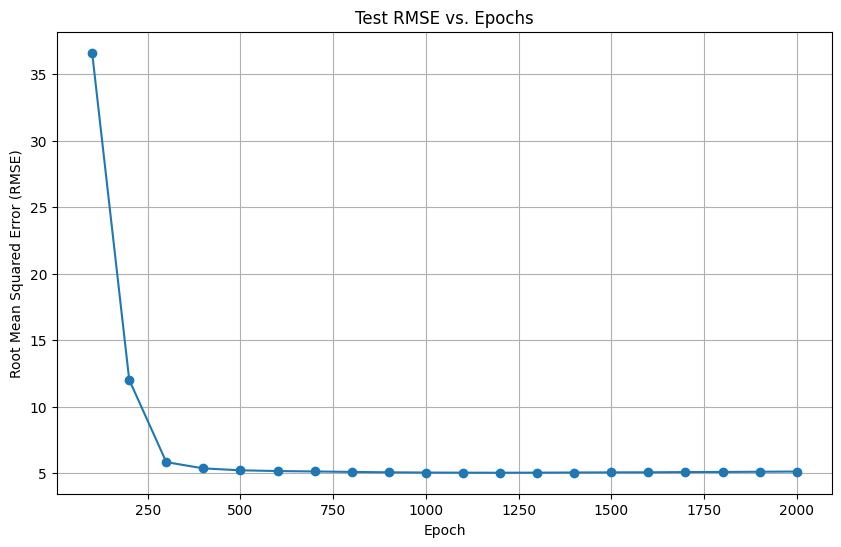

In [5]:
num_epochs = 2000

epoch_log = []
test_rmse_log = []

model.train()

print("-- Started Training ---")

for epoch in range(num_epochs):
  # Forward pass to compute loss
  outputs = model(X_train_tensor)
  loss = criterion(outputs, y_train_tensor)

  # Backward pass and optimization
  optimizer.zero_grad() # Clear previous gradients
  loss.backward()       # Compute new gradients
  optimizer.step()      # Update weights

  if (epoch+1) % 100 == 0:
    model.eval()

    with torch.no_grad():
      test_outputs = model(X_test_tensor)
      test_loss = criterion(test_outputs, y_test_tensor)
      test_rmse = torch.sqrt(test_loss).item()

      epoch_log.append(epoch + 1)
      test_rmse_log.append(test_rmse)

    model.train()

    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {loss.item():.4f}, Test RMSE: ${test_rmse:.4f}")

print("\n--- Training Finished ---")

# --- Plotting the Results ---
plt.figure(figsize=(10, 6))
plt.plot(epoch_log, test_rmse_log, marker='o')
plt.title('Test RMSE vs. Epochs')
plt.xlabel('Epoch')
plt.ylabel('Root Mean Squared Error (RMSE)')
plt.grid(True)
plt.show()



## Evaluation

In [6]:
model.eval()

# Run model on test data (not tracking gradients)
with torch.no_grad():
  test_outputs = model(X_test_tensor)
  test_loss = criterion(test_outputs, y_test_tensor)
  test_rmse = torch.sqrt(test_loss)

print(f"\nFinal Model Performance on Unseen Test Data:")
print(f"Test Loss (MSE): {test_loss.item():.4f}")
print(f"Test Root Mean Squared Error (RMSE): ${test_rmse:.4f}")


Final Model Performance on Unseen Test Data:
Test Loss (MSE): 26.2462
Test Root Mean Squared Error (RMSE): $5.1231
